# HOMEWORK TWO

# Part 1: Prep

###### We start by importing packages and data, visualizing ou data, and then preparing our datasets for regressions.

In [1]:
# Import packages we need
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.linear_model import Ridge, ElasticNet, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
# Import train and test datasets that have been downloaded from Kaggle
train_df = pd.read_csv("C:\\Users\\jacob\\Documents\\Datasets\\Homework2\\train.csv", header='infer')
test_df = pd.read_csv('C:\\Users\\jacob\\Documents\\Datasets\\Homework2\\test.csv')

## Visualizing Data

We visualize our data with scatterplots and heat maps to get a feel for correlations and relationships between variables

##### Heat Map
This heat map helps us see that some variables are highly correlated with each other, either negatively or positively. For example, the year built of the home  and  the year built of the house are very highly correlated. We also see that SalePrice is highly correlated with OverallQal, GrLivArea, and GarageArea. SalePrice also seems to be negatively correlated with Enclosed Porch and KitchenAbvGr. We'll look at scatter plots of these different variables. We also see that many dependent variables basically give the same information, for example 1stFlrSF and 2ndFlrSf, GarageCars and GarageArea. These can limit the predictive power of our linear regression model if we include all the variables in the model.

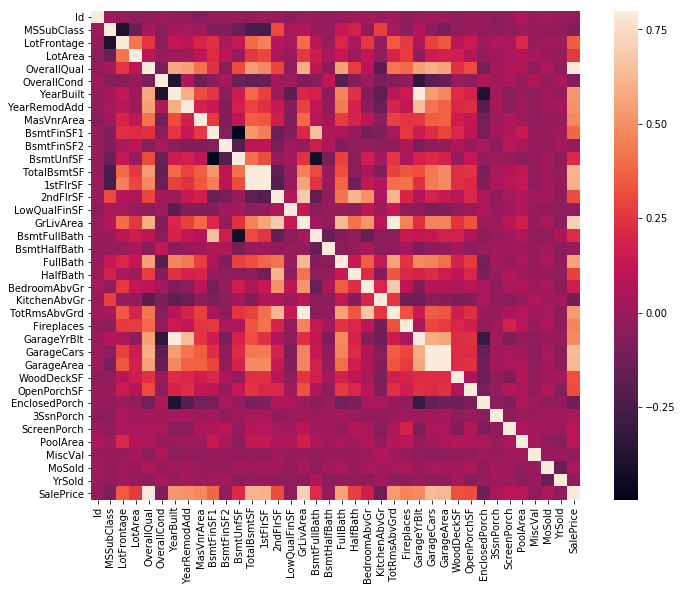

In [3]:
# We construct our heat map of the correlations of the variables in our train dataset.
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

##### Scatter Plots: SalePrice with GrLivArea, OverallQual, GarageArea, EnclosedPorch, and KitchenAbvGr

SalePrice and GrLivArea do seem to be highly correlated with the exception of two outliers. The relationship seems to be linear.

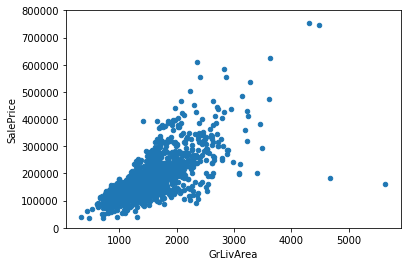

In [4]:
data = pd.concat([train_df['SalePrice'], train_df['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000))

Our OverallQual variable also has a clear correlation with SalePrice, although the relationship does not necessarily look linear. Taking the log transform of SalePrice may help with this. We will again look at this relationship after transforming SalePrice below.

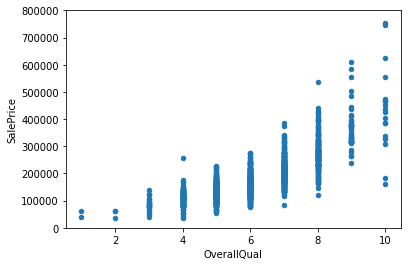

In [5]:
data = pd.concat([train_df['SalePrice'], train_df['OverallQual']], axis=1)
data.plot.scatter(x='OverallQual', y='SalePrice', ylim=(0,800000))

Although not as clear, GarageArea seems to also have a solid linear relationoship with SalePrice.

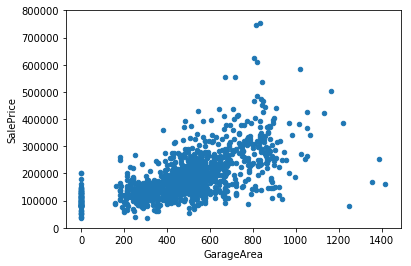

In [6]:
data = pd.concat([train_df['SalePrice'], train_df['GarageArea']], axis=1)
data.plot.scatter(x='GarageArea', y='SalePrice', ylim=(0,800000))

This is very interesting. Although a simple correlation suggests that SalePrice and Enclosed Porch are negatively correlated, looking at the scatter plot shows that they only seem to be since the most expensive homes do not have an enclosed porch. For those with an enclosed porch, the two variables are actually positively correlated. This suggests we need to make a dummy for EnclosedPorch=0.

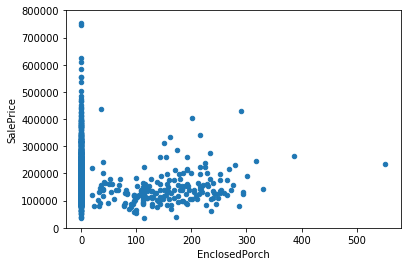

In [7]:
data = pd.concat([train_df['SalePrice'], train_df['EnclosedPorch']], axis=1)
data.plot.scatter(x='EnclosedPorch', y='SalePrice', ylim=(0,800000))

The story of this variables is similar to that of EnclosedPorch: we would be better served with dummies than with leaving the variable as an int.

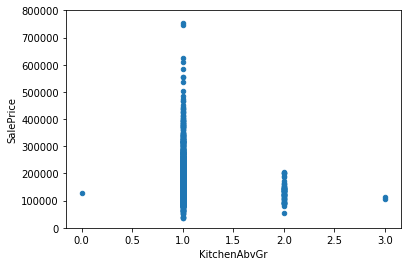

In [8]:
data = pd.concat([train_df['SalePrice'], train_df['KitchenAbvGr']], axis=1)
data.plot.scatter(x='KitchenAbvGr', y='SalePrice', ylim=(0,800000))

## Cleaning Data

We clean our data in 5 steps:

i) Transforming skewed data

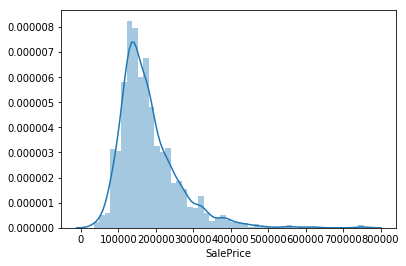

In [9]:
# We look at the distribution SalePrice as an example of a positively skewed variable.
# Next we will log transform the data to make it more normally distributed.
sns.distplot(train_df['SalePrice'])

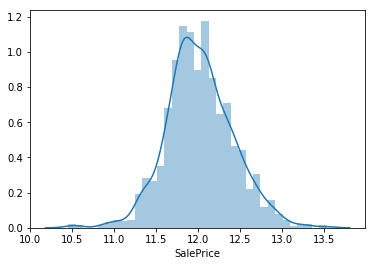

In [10]:
# We transorm this variable using the Log(1+x) transformation. Note that SalePrice is now more normally distributed.
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
sns.distplot(train_df['SalePrice'])

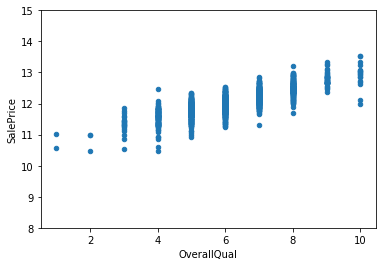

In [11]:
data = pd.concat([train_df['SalePrice'], train_df['OverallQual']], axis=1)
data.plot.scatter(x='OverallQual', y='SalePrice', ylim=(8,15))

In [12]:
# Before transforming any dependent variables, we combine the datasets. We do this because we want to do the same things to both
# datasets so our predictions will somewhat accurate. Note that we exclude the SalePrice and ID columns in  this comined dataset.
combine_df = pd.concat((train_df.loc[:,'MSSubClass':'SaleCondition'], 
                        test_df.loc[:,'MSSubClass':'SaleCondition'])) 

In [13]:
# Now we transform all the dependent variables that are positively skewed in our combined dataset.
numerics = combine_df.dtypes[combine_df.dtypes != "object"].index #Returns the index of all numeric columns
skeweds = combine_df[numerics].apply(lambda x: skew(x.dropna())) #This computes the skewness of each numeric variable.
skeweds = skeweds[skeweds > 0.75] #We create a dataset containing all the numeric variables skewed at least .75
skeweds = skeweds.index  #Returns the index of the skewed columns
combine_df[skeweds] = np.log1p(combine_df[skeweds]) #We log transform all the skewed columns

ii) Get dummies

In [14]:
# We create dummies for catagorical variables in both train and test datasets.
combine_df = pd.get_dummies(combine_df)

iii) Separate independent and dependent variables

In [15]:
# We now separate the data back into train and test datasets to be used for our regression.
xtrain = combine_df[:train_df.shape[0]]
xtest = combine_df[train_df.shape[0]:]
ytrain = train_df.drop(labels=[e for e in train_df.columns.tolist() if e not in ['SalePrice']], axis=1) #Our y vector

iv) Fill in missing values with the mean

In [16]:
# We fill in the missing values with the mean values. This can create problems, but we're guessing it's worth it. Also, this is
# not being used in publication, so we think it's ok in this case where we're really just trying to have good predictive power.
xtrain = xtrain.fillna(xtrain.mean())
xtest = xtest.fillna(test_df.mean())

v) Scale our data

In [17]:
# We scale our data which is very important for our regularized regressions.
scaler = StandardScaler()
scaler.fit(xtrain)
sc_xtrain = scaler.transform(xtrain)
sc_xtest = scaler.transform(xtest)

# Part 2: Modeling

Now we're ready to start our modeling. We begin with a basic linear regression that includes all our variables. Not the most elegant model, but it's a good starting point. If any model is worse than this we know it's not worth our time.
For what we're doing here, perhaps the most important assumption of this model is the linearity itself: we aren't allowing the fitted line to have any nonlinear form in any of the variables. Later we will essentially relax this restriction by using the poly kernal of the SVR model.

Our plan is 1)Linear Regression, 2)LASSO, 3)Ridge, 4)ElasticNet, 5)SVR, and 6)KNearestNeighbors Regression

## Linear Regression
Perhaps for the sake of consistency, we use the gridsearch model with the only option being whether or not to force the line through the origin. As would be expected, allowing for an intercept is preferred. Our Kaggle "score" from this model is 0.65, which is quite a bit worse than most of the other models.

In [18]:
# Very similar code will be used in each regression. We use gridsearch to search over different parameters. We find the best
# parameters and then use them to predict on the test dataset below. We export these predictions to a .csv file which we can 
# then upload to Kaggle to see how we did.
linreg_model = LinearRegression()
gridsearch = GridSearchCV(linreg_model, {'fit_intercept': [True, False]}, scoring="neg_mean_squared_error", cv=5)
gridsearch.fit(sc_xtrain, ytrain)
print("RMSE of Linear Regression is: ")
print(np.sqrt(-gridsearch.score(sc_xtrain, ytrain)))
print("Where the best parameter is: ")
print(gridsearch.best_params_)

RMSE of Linear Regression is: 
12.0207468765
Where the best parameter is: 
{'fit_intercept': False}


In [19]:
#Fit model, predict on test data, export predictions to .csv
linreg_model.fit(sc_xtrain, ytrain)
linreg_pred = np.expm1(linreg_model.predict(sc_xtest))
np.savetxt('C:\\Users\\jacob\\Documents\\Datasets\\Homework2\\LinRegPredictions.csv', linreg_pred)

C:\Users\jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in expm1
  This is separate from the ipykernel package so we can avoid doing imports until


## LASSO

Now we're ready to move onto something a little more sophisticated: the LASSO model. This model once again assumes linearity but is enhanced by the added component of regularization, in this case with respect to the L1 norm. We use the gridsearch to find the optimal 'alpha' value, using 5 fold cross validation as our measuring stick. This value essentially restricts the total magnitude of our coefficients (that's why it was so important to standardize). As we will see later during the KNearestNeighbors regression, this ends up setting close to half of the coefficients to 0 for our dependent variables. This allows the model to estimate the SalePrice with greater precision.

LASSO turns out to be our best model as far as Kaggle scoring goes, with a score of 0.15, good enough for around 2400 on the leaderboard. Not bad for such a simple regression.

In [20]:
# Now we try the LASSO model. We use the gridsearch feature to find the best alpha.
lasso_model = Lasso()
gridsearch = GridSearchCV(lasso_model, {'alpha': [ 0.1, 0.011, 0.01, 0.004, 0.003, 0.002, 0.001]},
                            scoring="neg_mean_squared_error", cv=3)
gridsearch.fit(sc_xtrain, ytrain)
print("RMSE of LASSO is: ")
print(np.sqrt(-gridsearch.score(sc_xtrain, ytrain)))
print("Where the best alpha is: ")
print(gridsearch.best_params_)

RMSE of LASSO is: 
0.0996990667281
Where the best alpha is: 
{'alpha': 0.003}


In [21]:
lasso = Lasso(alpha=0.003)
lasso.fit(sc_xtrain, ytrain)
lasso_pred = np.expm1(lasso.predict(sc_xtest))
np.savetxt('C:\\Users\\jacob\\Documents\\Datasets\\Homework2\\LassoPredictions.csv', lasso_pred)

## Ridge

This is very similar to the LASSO regression, but uses the L2 norm instead of the L1 norm. In practice this means that the Ridge regression cannot actually force any coefficients to 0. This is a limitation that ends up making LASSO a little better than Ridge. In fact, even though our Ridge gives a slightly better RMSE from our cross validation, LASSO performed much better on the Kaggle test data (0.15 rather than 0.6).

In [22]:
# Now we try the Ridge model. We use the gridsearch feature to find the best alpha.
ridge_model = Ridge()
gridsearch = GridSearchCV(ridge_model, {'alpha': [1000, 500, 341.3, 239, 238, 237, 10, 1, 0.1]},
                            scoring="neg_mean_squared_error", cv=3)
gridsearch.fit(sc_xtrain, ytrain)
print("RMSE of Ridge is: ")
print(np.sqrt(-gridsearch.score(sc_xtrain, ytrain)))
print("Where the best alpha is: ")
print(gridsearch.best_params_)

RMSE of Ridge is: 
0.0977938995717
Where the best alpha is: 
{'alpha': 238}


In [23]:
ridge = Ridge(alpha=238)
ridge.fit(sc_xtrain, ytrain)
ridge_pred = np.expm1(ridge.predict(sc_xtest))
np.savetxt('C:\\Users\\jacob\\Documents\\Datasets\\Homework2\\RidgePredictions.csv', ridge_pred)



## Elastic Net

Elastic Net is supposed to combine the strengths of LASSO and Ridge. In our case, however, it doesn't perform as well as either. For whatever reason, it is prone to overfitting. A more involved examination of the data would be necessary to find out why this might be since we would expect Elastic Net to be at least as good as LASSO. Even though it has a comparable RMSE from the cross validation, it's Kaggle predictions scored significantly lower (.19) than LASSO (.15).

In [24]:
# We turn off warnings to prevent warnings during the Elastic Net convergence.
# These warnings might have something to do with why Elastic Net isn't performing as well. It says that it can't converge.
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [25]:
elasticnet = ElasticNet(max_iter=10000)
gridsearch = GridSearchCV(elasticnet, {'alpha': [10, 1, 0.02, 0.01, 0.001], 'l1_ratio': [1, 0.31, 0.3, 0.29, 0]},
                            scoring="neg_mean_squared_error", cv=3)
gridsearch.fit(sc_xtrain, ytrain)
print("RMSE of ElasticNet is: ")
print(np.sqrt(-gridsearch.score(sc_xtrain, ytrain)))
print("Where the best parameters are: ")
print(gridsearch.best_params_)

RMSE of ElasticNet is: 
0.0997596089142
Where the best parameters are: 
{'alpha': 0.01, 'l1_ratio': 0.3}


In [26]:
enet = ElasticNet(alpha=0.01, l1_ratio=0.3)
enet.fit(sc_xtrain, ytrain)
enet_pred = np.expm1(enet.predict(sc_xtest))
np.savetxt('C:\\Users\\jacob\\Documents\\Datasets\\Homework2\\ENetPredictions.csv', enet_pred)

## SVR (poly kernel)

Now we're ready to move onto something more complicated. SVR is similar to a linear regression, but it uses the 'C' and 'epsilon' hyperparameters. 'C' is a parameter that controls how much the model is punished for having observations outside of its predicted "zone." In the case of SVR, the zone is a line, but a thick line instead of the usual infinitely thin line. 'epsilon' is what determines how "thick" our line is. Observations inside the line do not contribute to the cost function at all. Our model ends up drastically overfitting and not performing very well on the Kaggle test data.

In [27]:
svr = SVR(kernel='poly')
gridsearch = GridSearchCV(svr, {'C': [100, 10, 1], 'epsilon': [1, 0.1, 0.01], 'degree': [1, 2, 3]},
                          scoring="neg_mean_squared_error", cv=3)
gridsearch.fit(sc_xtrain, np.ravel(ytrain))
print("RMSE of SVR is: ")
print(np.sqrt(-gridsearch.score(sc_xtrain, np.ravel(ytrain))))
print("Where the best parameters are: ")
print(gridsearch.best_params_)

RMSE of SVR is: 
0.100656485867
Where the best parameters are: 
{'C': 1, 'degree': 1, 'epsilon': 0.01}


In [28]:
svr = SVR(kernel='poly', C=10, epsilon=0.01)
svr.fit(sc_xtrain, np.ravel(ytrain))
svr_pred = np.expm1(svr.predict(sc_xtest))
np.savetxt('C:\\Users\\jacob\\Documents\\Datasets\\Homework2\\SVRPredictions.csv', svr_pred)

C:\Users\jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in expm1
  This is separate from the ipykernel package so we can avoid doing imports until


# K Nearest Neighbors

Our last regression is the K Nearest Neighbors regressor. This is a pretty simple regression, but it requires more cleaning before running since it is more sensitive to dimensionality than the other models (especially when compared to the regularized regression). Basically, we look at which coefficients were set to 0 by LASSO and drop those columns from our dataset.

In [34]:
# Fit LASSO based on the parameters we found above.
lasso.fit(sc_xtrain, ytrain)
coef = pd.Series(lasso.coef_)

In [35]:
# We drop the columns that have a coefficient equal to 0. We check the shape of the resulting matrix to make sure it's smaller.
drop_cols = coef.isin([0]).values
ksc_xtrain = sc_xtrain[:,~drop_cols.flatten()]
ksc_xtest = sc_xtest[:,~drop_cols.flatten()]
ksc_xtrain.shape

(1460, 117)

After cleaning we're ready to run the regression. It performs pretty well. In fact, it's almost as good as Lasso, which is suprising considering it's a completely different setup.

In [36]:
# Now we perform our regression, searching over our various hyperparameters. 
clf = KNeighborsRegressor()
gridsearch = GridSearchCV(clf, {"n_neighbors": [3, 5, 7], "weights": ['uniform', 'distance'], 
                                'p': [1, 2]}, scoring='neg_mean_squared_error', cv=5)
gridsearch.fit(ksc_xtrain, ytrain)
print("RMSE of K Nearest Neighbors Regressor is: ")
print(np.sqrt(-gridsearch.score(ksc_xtrain, ytrain)))
print("Where the best parameters are: ")
print(gridsearch.best_params_)

RMSE of K Nearest Neighbors Regressor is: 
0.00103797438431
Where the best parameters are: 
{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


In [37]:
kneighbs = KNeighborsRegressor(n_neighbors = 5, weights='distance', p=1)
kneighbs.fit(ksc_xtrain, ytrain)
kneighb_pred = np.expm1(kneighbs.predict(ksc_xtest))
np.savetxt('C:\\Users\\jacob\\Documents\\Datasets\\Homework2\\KNeighbPredictions.csv', kneighb_pred)

# Conclusion

I don't think I would ever entrust this to Zillow. I have put many hours into this, but I would need to know the data a lot better before I would use it in business. Lasso has been our best model, but I that with some tweaking KNearestNeighbors and SVR can be almost as good or better. I also learned that how cross validation is performed has a huge effect on hyperparameter selection. When switching from 5 fold to 3 fold, my hyperparameters changed drastically, as did model performance. I thought the 5 fold cross validation  was causing me to overfit on the training data, but they actually performed better than the 3 fold models.